# DeepHubble

Here, we are exploring the standard DCGAN that was first introduced in [this paper](https://arxiv.org/pdf/1406.2661.pdf)

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as torchv
import torchx
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from PIL import Image

## Data

The ground truth data will be sampled from the Hubble eXtreme Deep Field (XDF). As seen below

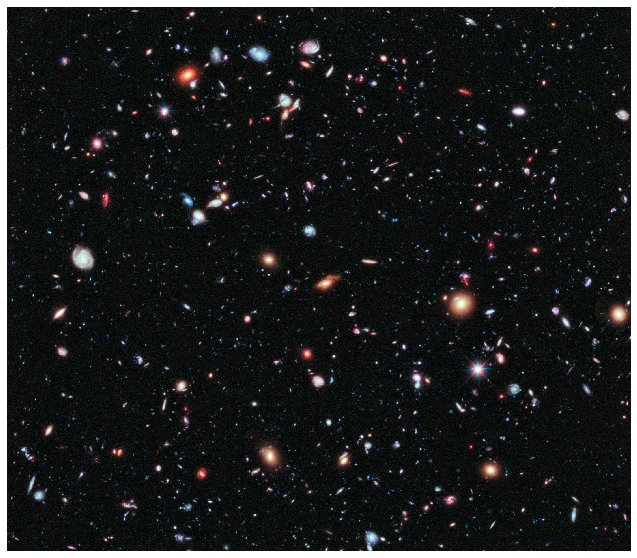

In [2]:
HubbleXDF = Image.open("../data/HubbleXDF_cropped.jpg")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(HubbleXDF)
plt.axis('off')
plt.show()

We will be sampling $256 \times 256$ size images from the deep field image for our model to learn the distribution for. This way, less of our images are mostly empty. For example:

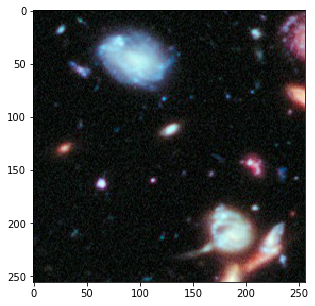

In [3]:
width = height = 256

random.seed(20120925)  # Date the XDF was captured: September 25th, 2012

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(torchv.transforms.Compose([
    torchv.transforms.RandomCrop((width, height)),
#     torchv.transforms.Resize((64, 64)),
])(HubbleXDF))
# plt.axis('off')
plt.show()

In [4]:
class Dataset:
    def __init__(self, size=9600):
        self.size = size
        
        self.transforms = torchv.transforms.Compose([
            torchv.transforms.RandomCrop((width, height)),
#             torchv.transforms.Resize((64, 64)),
            torchv.transforms.ToTensor()
        ])
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.transforms(HubbleXDF)

In [5]:
dataloader = torch.utils.data.DataLoader(
    Dataset(size=9600),
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)

## Model Architectures

The architectures for the generator and discriminator models are as follows:

In [6]:
class Generator(torchx.nn.Module):
    def __init__(self, input_size=100, output_channels=3):
        super().__init__()
        
        self.input_size = input_size
        self.output_channels = output_channels
        
        self.layers = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(self.input_size, 1024, 4, 1, 0),
            torchx.nn.ConvTranspose2dBatch(1024, 1024, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(1024, 512, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(512, 512, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(512, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torch.nn.ConvTranspose2d(256, self.output_channels, 3, 1, 1),
            torch.nn.Tanh()
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = x.view(-1, self.input_size, 1, 1)
        return self.layers(x)

        
generator = Generator().cuda()
generator.load("../data/checkpoints/best_generator.pt")

In [7]:
class Discriminator(torchx.nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        
        self.input_channels = input_channels
        
        self.conv = torch.nn.Sequential(
            torchx.nn.Conv2dBatch(self.input_channels, 32, 4, 2),
            torch.nn.MaxPool2d(2, 2),
            torchx.nn.Conv2dBatch(32, 64, 4, 2),
            torch.nn.MaxPool2d(2, 2),
            torchx.nn.Conv2dBatch(64, 128, 4, 2),
            torch.nn.MaxPool2d(2, 2),
            torchx.nn.Conv2dBatch(128, 256, 3, 1),
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 1),
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return torch.flatten(x, 0)

        
discriminator = Discriminator().cuda()
discriminator.load("../data/checkpoints/best_discriminator.pt")

## Pre-Training Generator

Before training, the output of our generator looks something like this:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


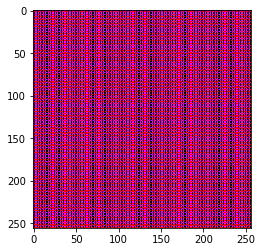

In [10]:
noise = torch.randn(1, 100).cuda()
fake_output = generator.forward(noise)

plt.imshow(np.moveaxis(fake_output.detach().cpu().numpy()[0], 0, -1))

As can be seen, it is essentially just random noise.

## Training

In [ ]:
criterion = torch.nn.BCELoss()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
epochs = 10
iteration = 0

with SummaryWriter("../data/runs") as writer:
    for epoch in trange(epochs):
        with tqdm(total=len(dataloader), leave=False) as progress:
            generator.train()
            discriminator.train()
            progress.set_description(f"epoch {epoch+1}")

            generator_loss = 0
            discriminator_loss = 0
            
            for i, imgs in enumerate(dataloader):
                imgs = imgs.cuda()

                discriminator.zero_grad()

                real_output = discriminator.forward(imgs)
                discriminator_err_real = criterion(
                    real_output,                               
                    torch.ones(imgs.shape[0]).cuda()
                )

                noise = torch.randn(imgs.shape[0], 100).cuda()
                fake_output = generator.forward(noise)
                discriminator_err_fake = criterion(
                    discriminator.forward(fake_output.detach()), 
                    torch.zeros(imgs.shape[0]).cuda()
                )

                discriminator_err = discriminator_err_real + discriminator_err_fake
                discriminator_err.backward()
                discriminator_optimizer.step()

                generator.zero_grad()

                generator_err = criterion(
                    discriminator.forward(fake_output), 
                    torch.ones(imgs.shape[0]).cuda()
                )
                generator_err.backward()
                generator_optimizer.step()

                progress.set_postfix(dloss="%.6f" % discriminator_err.item(), gloss="%.6f" % generator_err.item())
                progress.update()
                
                generator_loss += generator_err.item()
                discriminator_loss += discriminator_err.item()
                if i % 10 == 9:
                    iteration += 1
                    writer.add_scalar("Generator/Loss", generator_loss / 10, iteration)
                    writer.add_scalar("Discriminator/Loss", discriminator_loss / 10, iteration)
                    
                    generator_loss = 0
                    discriminator_loss = 0

            generator.save("../data/checkpoints/latest_generator.pt")
            discriminator.save("../data/checkpoints/latest_discriminator.pt")

## Generating Images

After training, we can use the generator to generate images and see what the generator has learnt

In [ ]:
noise = torch.randn(1, 100).cuda()
fake_output = generator.forward(noise)

In [ ]:
plt.imshow(np.moveaxis(fake_output.detach().cpu().numpy()[0], 0, -1))